In [1]:
import pandas  as pd
import re # For Regular Expressions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hakimam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

- NLTK stands for the Natural Language Toolkit. It is one of the oldest and most popular Python libraries for working with human language data (text).
- NLTK is a very large library. To save space on your computer, it doesn't come with all its dictionaries and datasets pre-installed. You have to "download" specific modules when you need them.
- WordNet is one of the most important "lexical databases" (dictionaries) for English.

In [2]:

# --- Sample Data ---
data = {
    'feedback_id': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
    'product': [
        'Credit Card', 'Personal Loan', 'BNPL', 'Savings Account', 
        'Credit Card', 'Money Transfers', 'Credit Card', 'Personal Loan',
        'Savings Account', 'BNPL', 'Money Transfers', 'Credit Card'
    ],
    'customer_feedback': [
        "I hate the <br>high interest rates on my credit card. It's too much! Call me at 555-1234. Visit our site: http://example.com",
        "My loan application was 'delayed'. This is SO frustrating!!!",
        "The Buy Now, Pay Later option is gr8. No issues :)",
        "I'm trying to open a savings account, but the app keeps crashing (iOS 17). Plz fix.",
        "Bad service for my credit card. Really disappointed. I will call again at 555-9876.",
        "",  # Empty feedback (EDA challenge)
        "My credit card statement is unclear. I need help understanding the fees.",
        "I applied for a loan 2 weeks ago... still NO ANSWER!!! Support is useless. #Angry #Finance",
        "How do I transfer money to my son in Europe? IBAN: DE123456789. Urgent!",
        "Love the BNPL feature, but the late fees are hidden in the T&Cs. Not cool.",
        "M-Pesa transfer failed but money was deducted. Transaction ID: 987654321.",
        "I love this bank! Best service ever. ❤️🌟" # Emoji case
    ]
}

df = pd.DataFrame(data)

In [3]:

print("\n--- Initial Raw Data ---")
print(df)


--- Initial Raw Data ---
    feedback_id          product  \
0             1      Credit Card   
1             2    Personal Loan   
2             3             BNPL   
3             4  Savings Account   
4             5      Credit Card   
5             6  Money Transfers   
6             7      Credit Card   
7             8    Personal Loan   
8             9  Savings Account   
9            10             BNPL   
10           11  Money Transfers   
11           12      Credit Card   

                                    customer_feedback  
0   I hate the <br>high interest rates on my credi...  
1   My loan application was 'delayed'. This is SO ...  
2   The Buy Now, Pay Later option is gr8. No issue...  
3   I'm trying to open a savings account, but the ...  
4   Bad service for my credit card. Really disappo...  
5                                                      
6   My credit card statement is unclear. I need he...  
7   I applied for a loan 2 weeks ago... still NO A...  
8

In [4]:

# --- EDA: Check for Missing/Empty Feedback ---
print("\n--- EDA: Missing/Empty Feedback ---")
# Count explicit NaNs (if any)
print(f"NaN count: {df['customer_feedback'].isnull().sum()}")
# Count empty strings (often more common in text data)
print(f"Empty string count: {(df['customer_feedback'] == '').sum()}")


--- EDA: Missing/Empty Feedback ---
NaN count: 0
Empty string count: 1


In [5]:

# --- EDA: Distribution of Products ---
print("\n--- EDA: Product Distribution ---")
print(df['product'].value_counts())


--- EDA: Product Distribution ---
product
Credit Card        4
Personal Loan      2
BNPL               2
Savings Account    2
Money Transfers    2
Name: count, dtype: int64


In [6]:
# --- EDA: Calculate and visualize word count (simple for demo) ---
df['word_count'] = df['customer_feedback'].apply(lambda x: len(str(x).split()) if str(x).strip() else 0)
print("\n--- EDA: Word Count Distribution ---")
print(df['word_count'].describe())


--- EDA: Word Count Distribution ---
count    12.000000
mean     12.083333
std       5.230302
min       0.000000
25%       9.750000
50%      12.500000
75%      15.250000
max      21.000000
Name: word_count, dtype: float64


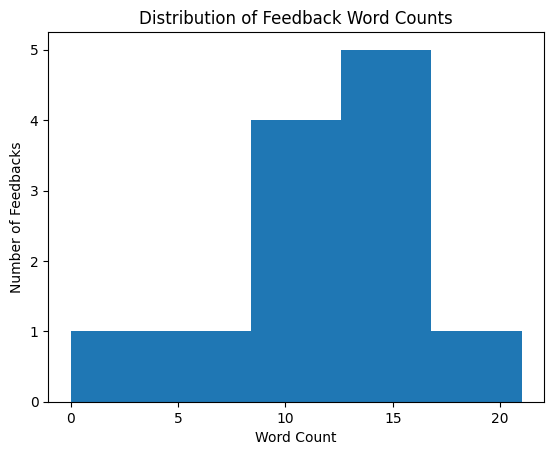

In [7]:
import matplotlib.pyplot as plt
plt.hist(df['word_count'], bins=5)
plt.title('Distribution of Feedback Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Number of Feedbacks')
plt.show()

In [8]:

# --- Preprocessing Step 1: Handle Missing/Empty Feedback ---
print("\n--- Preprocessing: Removing Empty Feedback ---")
df_cleaned = df[df['customer_feedback'].str.strip() != ''].copy()
print(f"Original rows: {len(df)}, Rows after removing empty: {len(df_cleaned)}")
print(df_cleaned[['feedback_id', 'customer_feedback']])


--- Preprocessing: Removing Empty Feedback ---
Original rows: 12, Rows after removing empty: 11
    feedback_id                                  customer_feedback
0             1  I hate the <br>high interest rates on my credi...
1             2  My loan application was 'delayed'. This is SO ...
2             3  The Buy Now, Pay Later option is gr8. No issue...
3             4  I'm trying to open a savings account, but the ...
4             5  Bad service for my credit card. Really disappo...
6             7  My credit card statement is unclear. I need he...
7             8  I applied for a loan 2 weeks ago... still NO A...
8             9  How do I transfer money to my son in Europe? I...
9            10  Love the BNPL feature, but the late fees are h...
10           11  M-Pesa transfer failed but money was deducted....
11           12           I love this bank! Best service ever. ❤️🌟


Here's where we start scrubbing! We define a function clean_text_noise that specifically targets HTML, website links, phone numbers (PII), and general punctuation. We also apply Case Folding here by converting everything to lowercase. Notice how the <br>, URL, and phone numbers are gone, and all letters are now small. This dramatically reduces the 'noise' for our AI.

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [t for t in tokens if t.isalpha() and t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

In [32]:
# --- Preprocessing Step 1: Handle Missing/Empty Feedback ---
print("\n--- Preprocessing: Removing Empty Feedback ---")
df_cleaned = df[df['customer_feedback'].str.strip() != ''].copy()
print(f"Original rows: {len(df)}, Rows after removing empty: {len(df_cleaned)}")
print(df_cleaned[['feedback_id', 'customer_feedback']])


--- Preprocessing: Removing Empty Feedback ---
Original rows: 12, Rows after removing empty: 11
    feedback_id                                  customer_feedback
0             1  I hate the <br>high interest rates on my credi...
1             2  My loan application was 'delayed'. This is SO ...
2             3  The Buy Now, Pay Later option is gr8. No issue...
3             4  I'm trying to open a savings account, but the ...
4             5  Bad service for my credit card. Really disappo...
6             7  My credit card statement is unclear. I need he...
7             8  I applied for a loan 2 weeks ago... still NO A...
8             9  How do I transfer money to my son in Europe? I...
9            10  Love the BNPL feature, but the late fees are h...
10           11  M-Pesa transfer failed but money was deducted....
11           12           I love this bank! Best service ever. ❤️🌟


In [33]:
# --- Preprocessing Step 2: Cleaning Text (HTML, URLs, Special Chars, PII) ---
import re

def clean_text_noise(text):
    text = str(text).lower()
    
    # STEP 1: Remove URLs first
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # STEP 2: Remove Phone Numbers (while the digits are still grouped)
    # This pattern looks for 7 to 10 digits in a row
    text = re.sub(r'\b\d{3}[-.\s]?\d{4}\b', '', text) # 7 digit format
    text = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', '', text) # 10 digit format
    text = re.sub(r'\b[A-Z]{2}\d{10,}\b', '', text, flags=re.I)   # Simple IBAN/IDs
    # STEP 3: Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # STEP 4: remove punctuation and special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    return text.strip()

# Apply the refined cleaning
df_cleaned['processed_feedback'] = df_cleaned['customer_feedback'].apply(clean_text_noise)

# # EDA Check: Length of cleaned text
# df['clean_length'] = df['processed_feedback'].apply(lambda x: len(x.split()))

# # Filter out rows that are now empty or too short
# df_cleaned = df[df['clean_length'] > 2]

print(df_cleaned[['customer_feedback', 'processed_feedback']].head())


                                   customer_feedback  \
0  I hate the <br>high interest rates on my credi...   
1  My loan application was 'delayed'. This is SO ...   
2  The Buy Now, Pay Later option is gr8. No issue...   
3  I'm trying to open a savings account, but the ...   
4  Bad service for my credit card. Really disappo...   

                                  processed_feedback  
0  i hate the high interest rates on my credit ca...  
1  my loan application was delayed this is so fru...  
2      the buy now pay later option is gr8 no issues  
3  im trying to open a savings account but the ap...  
4  bad service for my credit card really disappoi...  


Normalization. First, we break the sentence into individual tokens (words). Then, we use a list of common English stopwords to remove words like 'the' and 'is' because they don't carry much meaning. Finally, we apply lemmatization. Look at 'frustrating' becoming 'frustrate' and 'crashing' becoming 'crash'. The AI now sees 'frustrate' whether the customer wrote 'frustrating' or 'frustrated,' making its job much easier to group similar complaints.

In [51]:


# --- Preprocessing Step 3: Tokenization, Stopword Removal, Lemmatization ---

nltk.download('punkt')
nltk.download('punkt_tab')  
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def normalize_text(text):
    tokens = word_tokenize(text)
    
    # 1. Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    
    # 2. Apply Lemmatization for BOTH Nouns and Verbs
    # Notice we call .lemmatize(word, pos='v') to target verbs!
    lemmas = [lemmatizer.lemmatize(t, pos='v') for t in tokens]
    
    # 3. Apply it again for Nouns (default)
    lemmas = [lemmatizer.lemmatize(t, pos='n') for t in lemmas]
    
    return " ".join(lemmas)

# Run it again and watch "delayed" -> "delay" and "crashing" -> "crash"
df_cleaned['normalized_feedback'] = df_cleaned['processed_feedback'].apply(normalize_text)
print(df_cleaned[['processed_feedback', 'normalized__feedback']])




                                   processed_feedback  \
0   i hate the high interest rates on my credit ca...   
1   my loan application was delayed this is so fru...   
2       the buy now pay later option is gr8 no issues   
3   im trying to open a savings account but the ap...   
4   bad service for my credit card really disappoi...   
6   my credit card statement is unclear i need hel...   
7   i applied for a loan 2 weeks ago still no answ...   
8   how do i transfer money to my son in europe ib...   
9   love the bnpl feature but the late fees are hi...   
10  mpesa transfer failed but money was deducted t...   
11                 i love this bank best service ever   

                                 normalized__feedback  
0   hate high interest rat credit card much call v...  
1                    loan application delay frustrate  
2                      buy pay later option gr8 issue  
3   im try open saving account app keep crash io 1...  
4      bad service credit card real

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hakimam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\hakimam\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hakimam\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hakimam\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\hakimam\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
output_path = r"C:\Users\hakimam\Desktop\pproject\test5\data\processed\filtered_feedback.csv"
df_cleaned.to_csv(output_path, index=False)
print("Saved filtered_feedback to:", output_path)
